In [1]:
from data_reader import DataReader
import datasets
from tweet_to_vec import TweetToVec
import utils
from BiLSTM import BiLSTMModel
from evaluate import evaluate1
from evaluate import evaluate2
import os
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
import numpy as np
from torch import nn, optim
import torch.nn as nn

In [2]:
dr = DataReader('nlkt')
dr.read_dataset(datasets.binary_classes, False)
dr.read_dataset(datasets.ternary_classes, False)
embeddings = dr.read_embeddings('embeddings/kraby.txt', False)

binary_dataset = dr.get_dataset('binary')
binary_dataset = utils.extract_validation_from_training(binary_dataset)

ternary_dataset = dr.get_dataset('ternary')
ternary_dataset = utils.extract_validation_from_training(ternary_dataset)

In [3]:
def test(dataset, epochs, method, L, size, num_layers, dropout, prediction_method, equalize_training_classes, learning_rate, number_of_output_classes):
    batch_size = 32
    t2v = TweetToVec(embeddings, method, L)

    if equalize_training_classes:
        dataset = utils.equalize_training_classes(dataset)
    vectorized_dataset = t2v.vectorize_dataset(dataset)
    def gen_batched():
        batched_dataset = t2v.batch_dataset(vectorized_dataset, batch_size, True, True)
        return batched_dataset['training tweets'], batched_dataset['training tags']

    model = BiLSTMModel(size=size, embedding_dim=100,num_layers=num_layers, dropout=dropout, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=learning_rate)

    batched = t2v.batch_dataset(vectorized_dataset, batch_size, True, False)
    tweets = batched['validation tweets']
    tags = batched['validation tags']
    current_best_score = 0
    best_model_path = ""
    params_string = f'_number_of_output_classes_{number_of_output_classes}_method_{method}_L_{L}_size_{size}_num_layers_{num_layers}_dropout_{dropout}_prediction_method_{prediction_method}_equalize_training_classes_{equalize_training_classes}_learnig_rate_{learning_rate}'
    
    scores = []

    for i in range(epochs):
        model.train_model(gen_batched, 1)
        model.eval()
        predictions = model.predict(tweets)
        score = 0
        if number_of_output_classes == 2:
            score = evaluate1(predictions, tags)['balancedf']
            print(" balancedf score on valid =", score)
        else:
            score = evaluate2(predictions, tags)['microAverageFscore']
            print(" microAverageFscore score on valid =", score)  
        scores.append(score)  
        if score > current_best_score:
            if len(best_model_path) > 0:
                os.remove(best_model_path)
            current_best_score = score
            str_score = str(score * 100)
            str_score = str_score[:min(len(str_score), 5)]
            best_model_path = 'models/BiLSTM_' + str_score + params_string + '.model'
            torch.save(model.state_dict(), best_model_path)
    

    plt.plot(scores)
    plt.ylabel('scores on validation over epochs')
    plt.show()
    print("Best score = ", current_best_score)

In [4]:
def evaluate_on_test(filename, dataset, size, num_layers, dropout, L, prediction_method, method, number_of_output_classes):
    model = BiLSTMModel(size=size, embedding_dim=100,num_layers=num_layers, dropout=dropout, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=0.0001)
    model.load_state_dict(torch.load(filename))
    model.eval()

    t2v = TweetToVec(embeddings, method, L)
    
    vectorized_dataset = t2v.vectorize_dataset(dataset)

    batched = t2v.batch_dataset(vectorized_dataset, 1, True, False)
    tweets = batched['test tweets']
    tags = batched['test tags']

    predictions = model.predict(tweets)
    if number_of_output_classes == 2:
        score = evaluate1(predictions, tags)['balancedf']
        print(" balancedf score on test =", score)
    else:
        score = evaluate2(predictions, tags)['microAverageFscore']
        print(" microAverageFscore score on test =", score)

## Hyperparameters tuning of BiLSTM on binary problem

### First round of hyperparameters turning

After epoch 0 tot_loss = 213.79896545410156 balancedf score on valid = 0.38647342995169076
After epoch 1 tot_loss = 109.7884292602539 balancedf score on valid = 0.5094339622641509
After epoch 2 tot_loss = 65.47927856445312 balancedf score on valid = 0.4948453608247423
After epoch 3 tot_loss = 50.94845962524414 balancedf score on valid = 0.49397590361445787
After epoch 4 tot_loss = 38.2204704284668 balancedf score on valid = 0.4945054945054945
After epoch 5 tot_loss = 29.91525650024414 balancedf score on valid = 0.48205128205128206
After epoch 6 tot_loss = 26.172203063964844 balancedf score on valid = 0.508670520231214
After epoch 7 tot_loss = 22.2370548248291 balancedf score on valid = 0.4946236559139785
After epoch 8 tot_loss = 19.735815048217773 balancedf score on valid = 0.5
After epoch 9 tot_loss = 16.773479461669922 balancedf score on valid = 0.5207100591715977


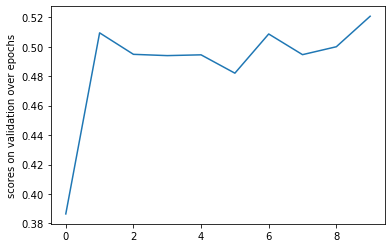

Best score =  0.5207100591715977


In [8]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=2)

After epoch 0 tot_loss = 201.28717041015625 balancedf score on valid = 0.4220183486238532
After epoch 1 tot_loss = 122.56356048583984 balancedf score on valid = 0.4518272425249169
After epoch 2 tot_loss = 91.07875061035156 balancedf score on valid = 0.44799999999999995
After epoch 3 tot_loss = 71.33321380615234 balancedf score on valid = 0.45662100456621
After epoch 4 tot_loss = 65.49002838134766 balancedf score on valid = 0.4684684684684684
After epoch 5 tot_loss = 56.19987869262695 balancedf score on valid = 0.5120772946859904
After epoch 6 tot_loss = 47.637359619140625 balancedf score on valid = 0.5123152709359605
After epoch 7 tot_loss = 44.668678283691406 balancedf score on valid = 0.5123152709359605
After epoch 8 tot_loss = 38.56584930419922 balancedf score on valid = 0.5073170731707317
After epoch 9 tot_loss = 35.624000549316406 balancedf score on valid = 0.4854368932038835


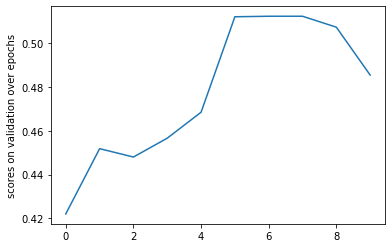

Best score =  0.5123152709359605


In [11]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d',
     L=30, 
     size=64, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 315.2221374511719 balancedf score on valid = 0.38636363636363635
After epoch 1 tot_loss = 246.5850067138672 balancedf score on valid = 0.4
After epoch 2 tot_loss = 216.180908203125 balancedf score on valid = 0.43046357615894043
After epoch 3 tot_loss = 201.460205078125 balancedf score on valid = 0.4048338368580061
After epoch 4 tot_loss = 190.65122985839844 balancedf score on valid = 0.4169381107491857
After epoch 5 tot_loss = 182.999755859375 balancedf score on valid = 0.4359861591695502
After epoch 6 tot_loss = 174.0218963623047 balancedf score on valid = 0.4246153846153846
After epoch 7 tot_loss = 165.7110595703125 balancedf score on valid = 0.435374149659864
After epoch 8 tot_loss = 162.62315368652344 balancedf score on valid = 0.41860465116279066
After epoch 9 tot_loss = 155.59860229492188 balancedf score on valid = 0.4125


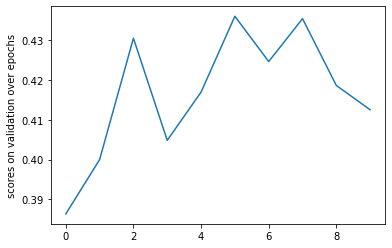

Best score =  0.4359861591695502


In [14]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

### Second iterations round (small changed of the best from the previous round)

After epoch 0 tot_loss = 222.54710388183594 balancedf score on valid = 0.40776699029126207
After epoch 1 tot_loss = 134.0852508544922 balancedf score on valid = 0.42023346303501946
After epoch 2 tot_loss = 103.5659408569336 balancedf score on valid = 0.4655172413793103
After epoch 3 tot_loss = 85.05462646484375 balancedf score on valid = 0.4916666666666666
After epoch 4 tot_loss = 73.0675048828125 balancedf score on valid = 0.4666666666666667
After epoch 5 tot_loss = 63.06926345825195 balancedf score on valid = 0.45161290322580644
After epoch 6 tot_loss = 53.92760467529297 balancedf score on valid = 0.45614035087719296
After epoch 7 tot_loss = 49.82862091064453 balancedf score on valid = 0.4372093023255814
After epoch 8 tot_loss = 47.04957962036133 balancedf score on valid = 0.5
After epoch 9 tot_loss = 39.74671936035156 balancedf score on valid = 0.49302325581395345


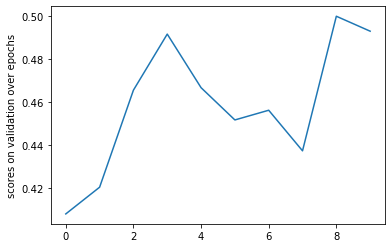

Best score =  0.5


In [15]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d',
     L=30, 
     size=64, 
     num_layers=3, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 202.4480743408203 balancedf score on valid = 0.5041322314049588
After epoch 1 tot_loss = 103.50382995605469 balancedf score on valid = 0.4615384615384615
After epoch 2 tot_loss = 66.11953735351562 balancedf score on valid = 0.5277777777777778
After epoch 3 tot_loss = 48.156917572021484 balancedf score on valid = 0.5054945054945055
After epoch 4 tot_loss = 36.12253189086914 balancedf score on valid = 0.5172413793103449
After epoch 5 tot_loss = 30.756797790527344 balancedf score on valid = 0.5180722891566265
After epoch 6 tot_loss = 24.31250762939453 balancedf score on valid = 0.5360824742268041
After epoch 7 tot_loss = 21.29900360107422 balancedf score on valid = 0.5217391304347825
After epoch 8 tot_loss = 18.149473190307617 balancedf score on valid = 0.4867724867724868
After epoch 9 tot_loss = 17.629743576049805 balancedf score on valid = 0.5297297297297296


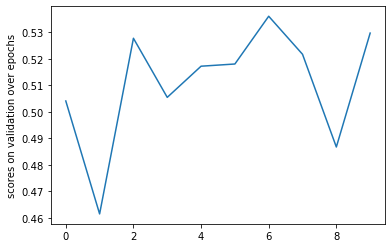

Best score =  0.5360824742268041


: 

In [16]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d',
     L=30, 
     size=64, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.005, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 213.92022705078125 balancedf score on valid = 0.4765625000000001
After epoch 1 tot_loss = 131.30352783203125 balancedf score on valid = 0.4719101123595506
After epoch 2 tot_loss = 100.6215591430664 balancedf score on valid = 0.4824902723735408
After epoch 3 tot_loss = 88.20684814453125 balancedf score on valid = 0.49777777777777776
After epoch 4 tot_loss = 78.10985565185547 balancedf score on valid = 0.5
After epoch 5 tot_loss = 65.20911407470703 balancedf score on valid = 0.5021645021645021
After epoch 6 tot_loss = 57.5599479675293 balancedf score on valid = 0.47747747747747743
After epoch 7 tot_loss = 52.2277946472168 balancedf score on valid = 0.5
After epoch 8 tot_loss = 47.99898147583008 balancedf score on valid = 0.4799999999999999
After epoch 9 tot_loss = 41.21592330932617 balancedf score on valid = 0.5120772946859904


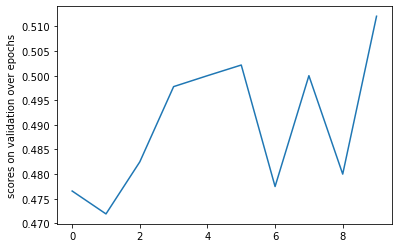

Best score =  0.5120772946859904


In [5]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=3, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.005,
     number_of_output_classes=2)

After epoch 0 tot_loss = 241.39523315429688 balancedf score on valid = 0.46545454545454545
After epoch 1 tot_loss = 119.69208526611328 balancedf score on valid = 0.47619047619047616
After epoch 2 tot_loss = 91.4775161743164 balancedf score on valid = 0.49315068493150693
After epoch 3 tot_loss = 72.1543197631836 balancedf score on valid = 0.47342995169082125
After epoch 4 tot_loss = 60.25251007080078 balancedf score on valid = 0.4956521739130435
After epoch 5 tot_loss = 56.807193756103516 balancedf score on valid = 0.4791666666666667
After epoch 6 tot_loss = 44.521942138671875 balancedf score on valid = 0.4912280701754386
After epoch 7 tot_loss = 40.946998596191406 balancedf score on valid = 0.4811320754716981
After epoch 8 tot_loss = 34.95488739013672 balancedf score on valid = 0.5136612021857925
After epoch 9 tot_loss = 33.94648361206055 balancedf score on valid = 0.5


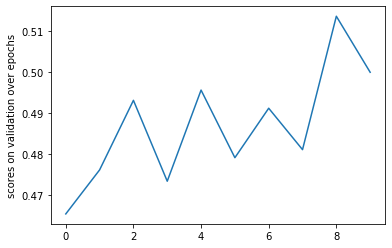

Best score =  0.5136612021857925


In [6]:
test(dataset=binary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.01,
     number_of_output_classes=2)

### Evaluation of the best BiLSTM model on binary problem

In [10]:
evaluate_on_test('models/BiLSTM_52.07_number_of_output_classes_2_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.2_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.005.model',
                 dataset=binary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.2,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.4263959390862944


In [13]:
evaluate_on_test('models/BiLSTM_51.23_number_of_output_classes_2_method_fixed_length_2d_L_30_size_64_num_layers_2_dropout_0.2_prediction_method_max_equalize_training_classes_True_learnig_rate_0.005.model',
                 dataset=binary_dataset,
                 size=64,
                 num_layers=2,
                 dropout=0.2,
                 L=30,
                 prediction_method='max',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.5877551020408163


## Hyperparameters turning of BiLSTM on ternary problem

### First tryouts based on best models from the binary problem

After epoch 0 tot_loss = 527.3115844726562 microAverageFscore score on valid = 0.8286852589641436
After epoch 1 tot_loss = 212.52049255371094 microAverageFscore score on valid = 0.8127490039840638
After epoch 2 tot_loss = 121.60982513427734 microAverageFscore score on valid = 0.853585657370518
After epoch 3 tot_loss = 83.43638610839844 microAverageFscore score on valid = 0.8555776892430279
After epoch 4 tot_loss = 60.59873580932617 microAverageFscore score on valid = 0.8754980079681275


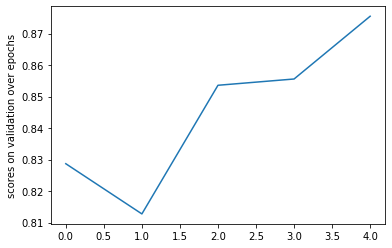

Best score =  0.8754980079681275


In [7]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0005, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 693.7352905273438 microAverageFscore score on valid = 0.7250996015936254
After epoch 1 tot_loss = 458.58489990234375 microAverageFscore score on valid = 0.75
After epoch 2 tot_loss = 342.2119140625 microAverageFscore score on valid = 0.7898406374501991
After epoch 3 tot_loss = 289.6365051269531 microAverageFscore score on valid = 0.7659362549800797
After epoch 4 tot_loss = 248.9896240234375 microAverageFscore score on valid = 0.8077689243027888


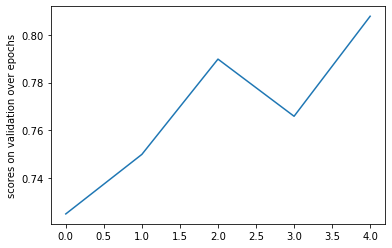

Best score =  0.8077689243027888


In [9]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=3, 
     dropout=0.5, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0005, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 450.6522216796875 microAverageFscore score on valid = 0.8266932270916335
After epoch 1 tot_loss = 146.15757751464844 microAverageFscore score on valid = 0.8735059760956176
After epoch 2 tot_loss = 77.22767639160156 microAverageFscore score on valid = 0.8774900398406374
After epoch 3 tot_loss = 55.0455436706543 microAverageFscore score on valid = 0.8944223107569721
After epoch 4 tot_loss = 37.48762893676758 microAverageFscore score on valid = 0.896414342629482


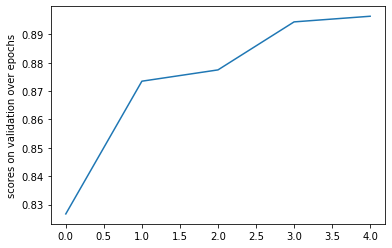

Best score =  0.896414342629482


In [5]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 588.33984375 microAverageFscore score on valid = 0.7898406374501991
After epoch 1 tot_loss = 309.62493896484375 microAverageFscore score on valid = 0.7838645418326694
After epoch 2 tot_loss = 199.86988830566406 microAverageFscore score on valid = 0.8276892430278886
After epoch 3 tot_loss = 151.869140625 microAverageFscore score on valid = 0.8456175298804781
After epoch 4 tot_loss = 121.77013397216797 microAverageFscore score on valid = 0.8824701195219125
After epoch 5 tot_loss = 104.18812561035156 microAverageFscore score on valid = 0.8555776892430279
After epoch 6 tot_loss = 85.85496520996094 microAverageFscore score on valid = 0.8784860557768924
After epoch 7 tot_loss = 75.44490051269531 microAverageFscore score on valid = 0.8804780876494024
After epoch 8 tot_loss = 68.99469757080078 microAverageFscore score on valid = 0.8864541832669323
After epoch 9 tot_loss = 59.200782775878906 microAverageFscore score on valid = 0.896414342629482


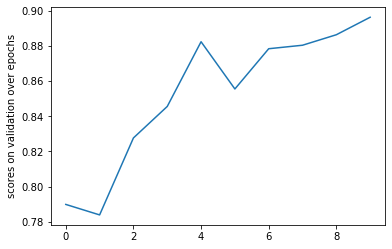

Best score =  0.896414342629482


In [6]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0005, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 425.28692626953125 microAverageFscore score on valid = 0.7529880478087649
After epoch 1 tot_loss = 136.5152587890625 microAverageFscore score on valid = 0.8565737051792828
After epoch 2 tot_loss = 80.77568054199219 microAverageFscore score on valid = 0.8446215139442231
After epoch 3 tot_loss = 52.475677490234375 microAverageFscore score on valid = 0.896414342629482
After epoch 4 tot_loss = 40.5498046875 microAverageFscore score on valid = 0.9033864541832669
After epoch 5 tot_loss = 32.045372009277344 microAverageFscore score on valid = 0.8864541832669323
After epoch 6 tot_loss = 22.910680770874023 microAverageFscore score on valid = 0.9143426294820717
After epoch 7 tot_loss = 20.106842041015625 microAverageFscore score on valid = 0.9043824701195219
After epoch 8 tot_loss = 16.481769561767578 microAverageFscore score on valid = 0.9023904382470119
After epoch 9 tot_loss = 14.381053924560547 microAverageFscore score on valid = 0.8914342629482072


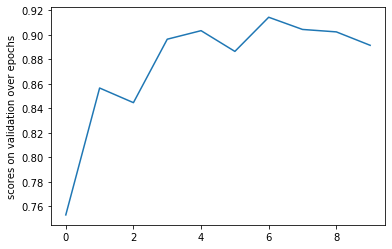

Best score =  0.9143426294820717


In [7]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=3)

After epoch 0 tot_loss = 433.8288879394531 microAverageFscore score on valid = 0.8167330677290838
After epoch 1 tot_loss = 141.0228729248047 microAverageFscore score on valid = 0.850597609561753
After epoch 2 tot_loss = 78.71429443359375 microAverageFscore score on valid = 0.8715139442231077
After epoch 3 tot_loss = 54.62766647338867 microAverageFscore score on valid = 0.901394422310757
After epoch 4 tot_loss = 39.662109375 microAverageFscore score on valid = 0.8884462151394422
After epoch 5 tot_loss = 30.670080184936523 microAverageFscore score on valid = 0.8934262948207171
After epoch 6 tot_loss = 21.694162368774414 microAverageFscore score on valid = 0.8884462151394422
After epoch 7 tot_loss = 22.33716583251953 microAverageFscore score on valid = 0.899402390438247
After epoch 8 tot_loss = 16.86423683166504 microAverageFscore score on valid = 0.9023904382470119
After epoch 9 tot_loss = 13.988748550415039 microAverageFscore score on valid = 0.8904382470119522


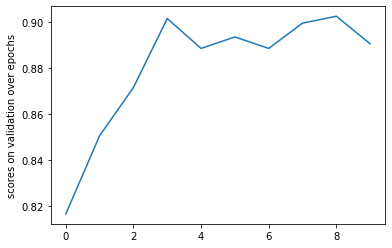

Best score =  0.9023904382470119


In [10]:
test(dataset=ternary_dataset, 
     epochs=10,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=3)

### Evaluation of the best BiLSTM model on ternary problem

In [8]:
evaluate_on_test('models/BiLSTM_91.43_number_of_output_classes_3_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.2_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.001.model',
                 dataset=ternary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.2,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=3)

 microAverageFscore score on test = 0.881


In [9]:
evaluate_on_test('models/BiLSTM_89.64_number_of_output_classes_3_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.5_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.0005.model',
                 dataset=ternary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.5,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=3)

 microAverageFscore score on test = 0.882
